In [87]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
from typing import Dict, Any
from collections import Counter

import numpy as np
import pandas as pd
import sklearn as sk
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, 
    average_precision_score, precision_recall_curve, plot_precision_recall_curve, make_scorer
)
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 250
import dvu  # for visualization

import imodels

# change working directory to project root
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../..')

from experiments.compare_models import get_dataset, get_comparison_result, get_best_models_under_complexity
from experiments.models.stablelinear import StableLinearClassifier
from experiments.models.stableskope import StableSkopeClassifier
from experiments.notebooks import viz
    
MODEL_COMPARISON_PATH = 'experiments/comparison_data/'

datasets = [
        ("breast-cancer", 13),
        ("breast-w", 15),
        ("credit-g", 31),
        ("haberman", 43),
        ("heart", 1574),
        ("labor", 4),
        ("vote", 56),
    ]

np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# dataset stats

In [80]:
metadata = []
columns = ['name', 'samples', 'features', 'class 0 ct', 'class 1 ct', 'majority class %']
for dataset_name, data_id in datasets:
    dataset = fetch_openml(data_id=data_id, as_frame=False)
    shape = dataset.data.shape
    class_counts = np.unique(dataset.target, return_counts=True)[1]
    metadata.append([dataset_name, shape[0], shape[1], class_counts[0], class_counts[1], np.max(class_counts) / np.sum(class_counts)])
pd.DataFrame(metadata, columns=columns).set_index('name')

,samples,features,class 0 ct,class 1 ct,majority class %
name,,,,,
breast-cancer,286,9,201,85,0.702797
breast-w,699,9,458,241,0.655222
credit-g,1000,20,300,700,0.700000
haberman,306,3,225,81,0.735294
heart,270,13,150,120,0.555556
labor,57,16,20,37,0.649123
vote,435,16,267,168,0.613793


- BRL fit .rules_
- try different complexity levels

Done
- make test and val estimators exact same to mke stablerules test comparison accurate
- rethink train/val/test system
- include brs, grl, oner on train data
- rerun comps including average_precision_score

In [75]:
ds = [13, 15, 31, 43, 1574, 4, 56]
rocauc_data = {d:[] for d in ds}
avg_prec_data = {d:[] for d in ds}
prec_data = {d:[] for d in ds}
rec_data = {d:[] for d in ds}
for d in ds:
    all_rules = []
    x, y = get_dataset(d)
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=1)
    weak_learners = [
        ('skope_rules', imodels.SkopeRulesClassifier),
        ('rulefit', imodels.RuleFitClassifier),
        ('fplasso', imodels.FPLassoClassifier),
        ('fpskope', imodels.FPSkopeClassifier),
        ('brs', imodels.BoostedRulesClassifier)
    ]
    weak_learner_inst = get_best_models_under_complexity(5, weak_learners)
    for m in weak_learner_inst:
        m.fit(xtrain, ytrain)
        rocauc_data[d].append(roc_auc_score(ytest, m.predict_proba(xtest)[:, 1]))
        avg_prec_data[d].append(average_precision_score(ytest, m.predict_proba(xtest)[:, 1]))
    ensemble_kwargs = {'weak_learners': weak_learner_inst, 'max_complexity': 5}
    ensembles = (
        [StableLinearClassifier(**ensemble_kwargs, min_mult=m) for m in [0, 1, 2]]
        + [StableLinearClassifier(**ensemble_kwargs, penalty='l2', min_mult=m) for m in [0, 1, 2]]
        + [StableSkopeClassifier(**ensemble_kwargs, min_mult=m) for m in [0, 1, 2]]
    )
    for m in ensembles:
        m.fit(xtrain, ytrain)
        rocauc_data[d].append(roc_auc_score(ytest, m.predict_proba(xtest)[:, 1]))
        avg_prec_data[d].append(average_precision_score(ytest, m.predict_proba(xtest)[:, 1]))

/Users/keyan/anaconda3/envs/imodels-3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [76]:
ind = ['skp', 'rf', 'fpl', 'fps', 'brs', 
       'ensemble-lasso-md0', 'ensemble-lasso-md1', 'ensemble-lasso-md2',
       'ensemble-ridge-md0', 'ensemble-ridge-md1', 'ensemble-ridge-md2', 
       'ensemble-skope-md0', 'ensemble-skope-md1', 'ensemble-skope-md2']
res_rocauc = pd.DataFrame(rocauc_data, index=ind)
res_avg_prec = pd.DataFrame(avg_prec_data, index=ind)
res_rocauc['mean'] = res_rocauc.mean(axis=1)
res_avg_prec['mean'] = res_avg_prec.mean(axis=1)

In [77]:
res_rocauc.style.background_gradient()

,13,15,31,43,1574,4,56,mean
skp,0.653617,0.986768,0.703739,0.740926,0.659722,0.571429,0.937785,0.750569
rf,0.500000,0.993012,0.743666,0.461887,0.875868,0.892857,0.937785,0.772154
fpl,0.500000,0.996432,0.784628,0.461887,0.886285,0.964286,0.937785,0.790186
fps,0.653617,0.984984,0.566877,0.703267,0.865885,0.723214,0.971842,0.781384
brs,0.631915,0.989295,0.730766,0.747278,0.832465,0.955357,0.988204,0.839326
ensemble-lasso-md0,0.500000,0.996878,0.785857,0.772686,0.889757,0.892857,0.990487,0.832646
ensemble-lasso-md1,0.500000,0.996878,0.784552,0.461887,0.893229,0.875000,0.990487,0.786005
ensemble-lasso-md2,0.500000,0.995094,0.791462,0.461887,0.892361,0.892857,0.990487,0.789164
ensemble-ridge-md0,0.711915,0.997472,0.788007,0.762704,0.904514,0.910714,0.991629,0.866708
ensemble-ridge-md1,0.709362,0.997175,0.797835,0.729129,0.908854,0.928571,0.990868,0.865971


In [78]:
res_avg_prec.style.background_gradient()

,13,15,31,43,1574,4,56,mean
skp,0.460580,0.993613,0.813832,0.869176,0.579696,0.584970,0.867801,0.738524
rf,0.347222,0.996702,0.857149,0.725287,0.886254,0.875546,0.867801,0.793709
fpl,0.347222,0.998546,0.884856,0.725287,0.900370,0.970486,0.867801,0.813510
fps,0.460580,0.991681,0.778654,0.839230,0.873179,0.679167,0.926709,0.792743
brs,0.445945,0.994754,0.840002,0.864684,0.831000,0.959375,0.971320,0.843869
ensemble-lasso-md0,0.347222,0.998682,0.887107,0.891890,0.904530,0.895685,0.980373,0.843641
ensemble-lasso-md1,0.347222,0.998619,0.885233,0.725287,0.903823,0.833879,0.980373,0.810634
ensemble-lasso-md2,0.347222,0.997802,0.890672,0.725287,0.903129,0.875546,0.980373,0.817147
ensemble-ridge-md0,0.670105,0.998933,0.889458,0.894710,0.910065,0.920685,0.983273,0.895318
ensemble-ridge-md1,0.662168,0.998730,0.895196,0.880774,0.912028,0.931796,0.981357,0.894578


In [4]:
np.random.seed(0)
x, y = get_dataset(1574)
xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(x, y, random_state=0)
m = imodels.BayesianRuleListClassifier()
# m.fit(xtrain, ytrain)
# print(roc_auc_score(ytest, m.predict_proba(xtest)[:, 1]))
# # print(m.rules_)

In [19]:
from imodels.util.convert import tree_to_rules

np.random.seed(0)
x, y = get_dataset(13)
xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(x, y, test_size=0.2, random_state=0)
m = imodels.BoostedRulesClassifier(n_estimators=10)
# m.fit(xtrain, ytrain)
# m.predict_proba(xtest)
# print(average_precision_score(ytest, m.predict_proba(xtest)[:, 1]))

In [253]:
KFold(n_splits=4, random_state=0, shuffle=True)

KFold(n_splits=4, random_state=0, shuffle=True)

In [261]:
len(sk.model_selection.train_test_split(np.arange(x.shape[0]), test_size=0.2, random_state=0))

2

In [282]:
from experiments.compare_models import get_complexity

In [20]:
np.random.seed(0)
scores = {
    'accuracy': make_scorer(accuracy_score),
    'ROCAUC': make_scorer(roc_auc_score, needs_proba=True), 
    'prec_recall_auc': make_scorer(average_precision_score, needs_proba=True),
}
sk.model_selection.cross_validate(m, x, y, 
#                                   cv=KFold(n_splits=4, random_state=0, shuffle=True),
                                  cv=[sk.model_selection.train_test_split(np.arange(x.shape[0]), test_size=0.2, random_state=0)],
                                  scoring=scores)

{'fit_time': array([0.00954795]),
 'score_time': array([0.03038025]),
 'test_accuracy': array([0.70689655]),
 'test_ROCAUC': array([0.74368687]),
 'test_prec_recall_auc': array([0.65940443])}

In [279]:
scores['accuracy'](m, xtest, ytest)

0.7068965517241379

# complexity vs. ROC Area plot for all models

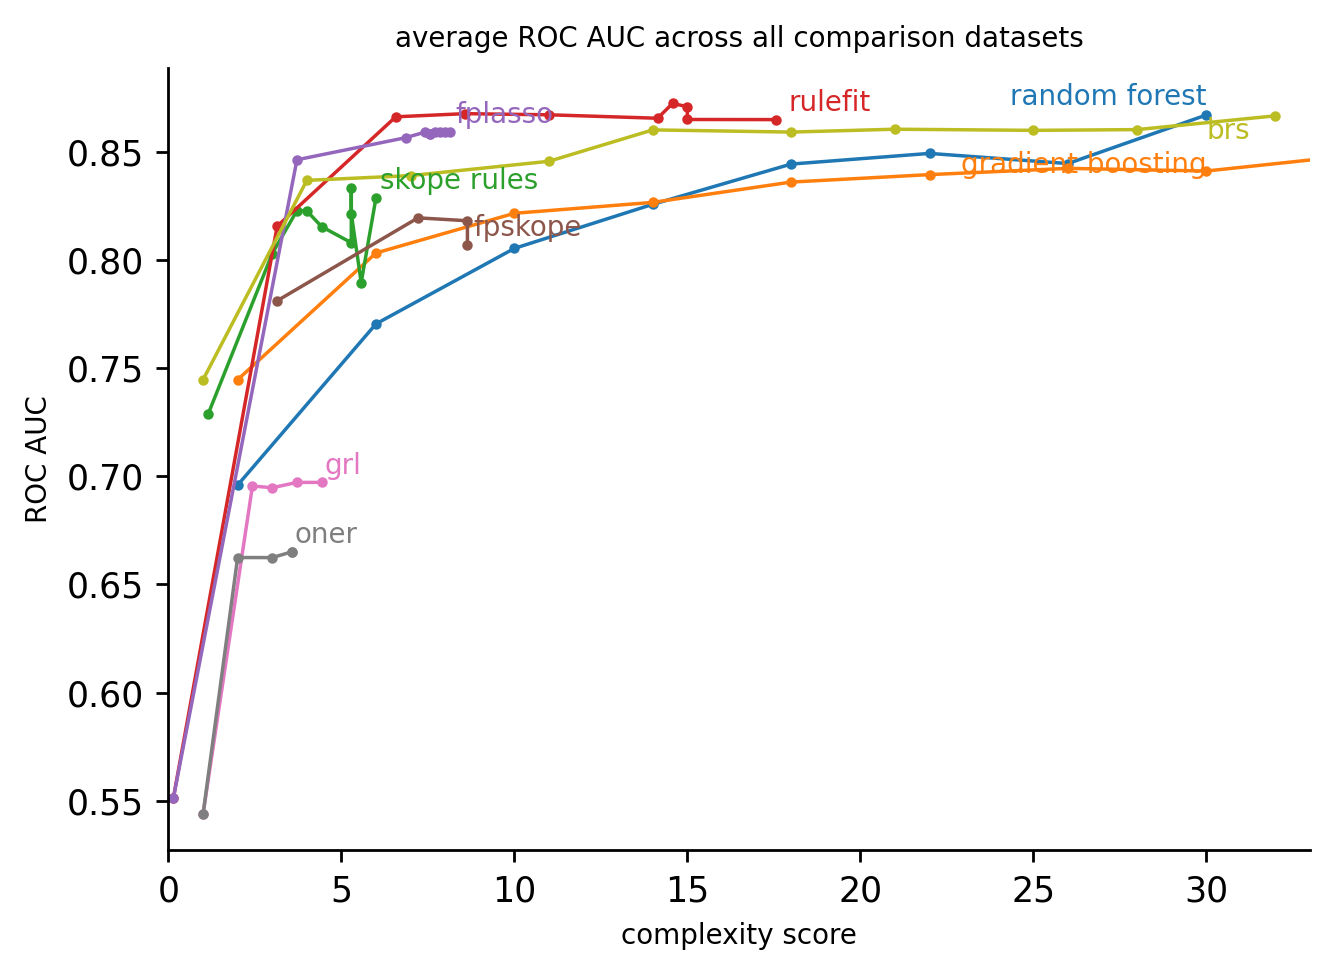

In [129]:
test_models = [
    'random_forest', 
    'gradient_boosting', 
    'skope_rules', 
    'rulefit', 
    'fplasso', 
    'fpskope',
    'brl',
    'grl',
    'oner',
    'brs']
test_results = [get_comparison_result(MODEL_COMPARISON_PATH, mname, test=True)
                for mname in test_models]
viz.viz_comparison_test_average(test_results)
plt.show()

In [184]:
np.linspace(1, 16, 8, dtype=int)

array([ 1,  3,  5,  7,  9, 11, 13, 16])

**check individual datasets**

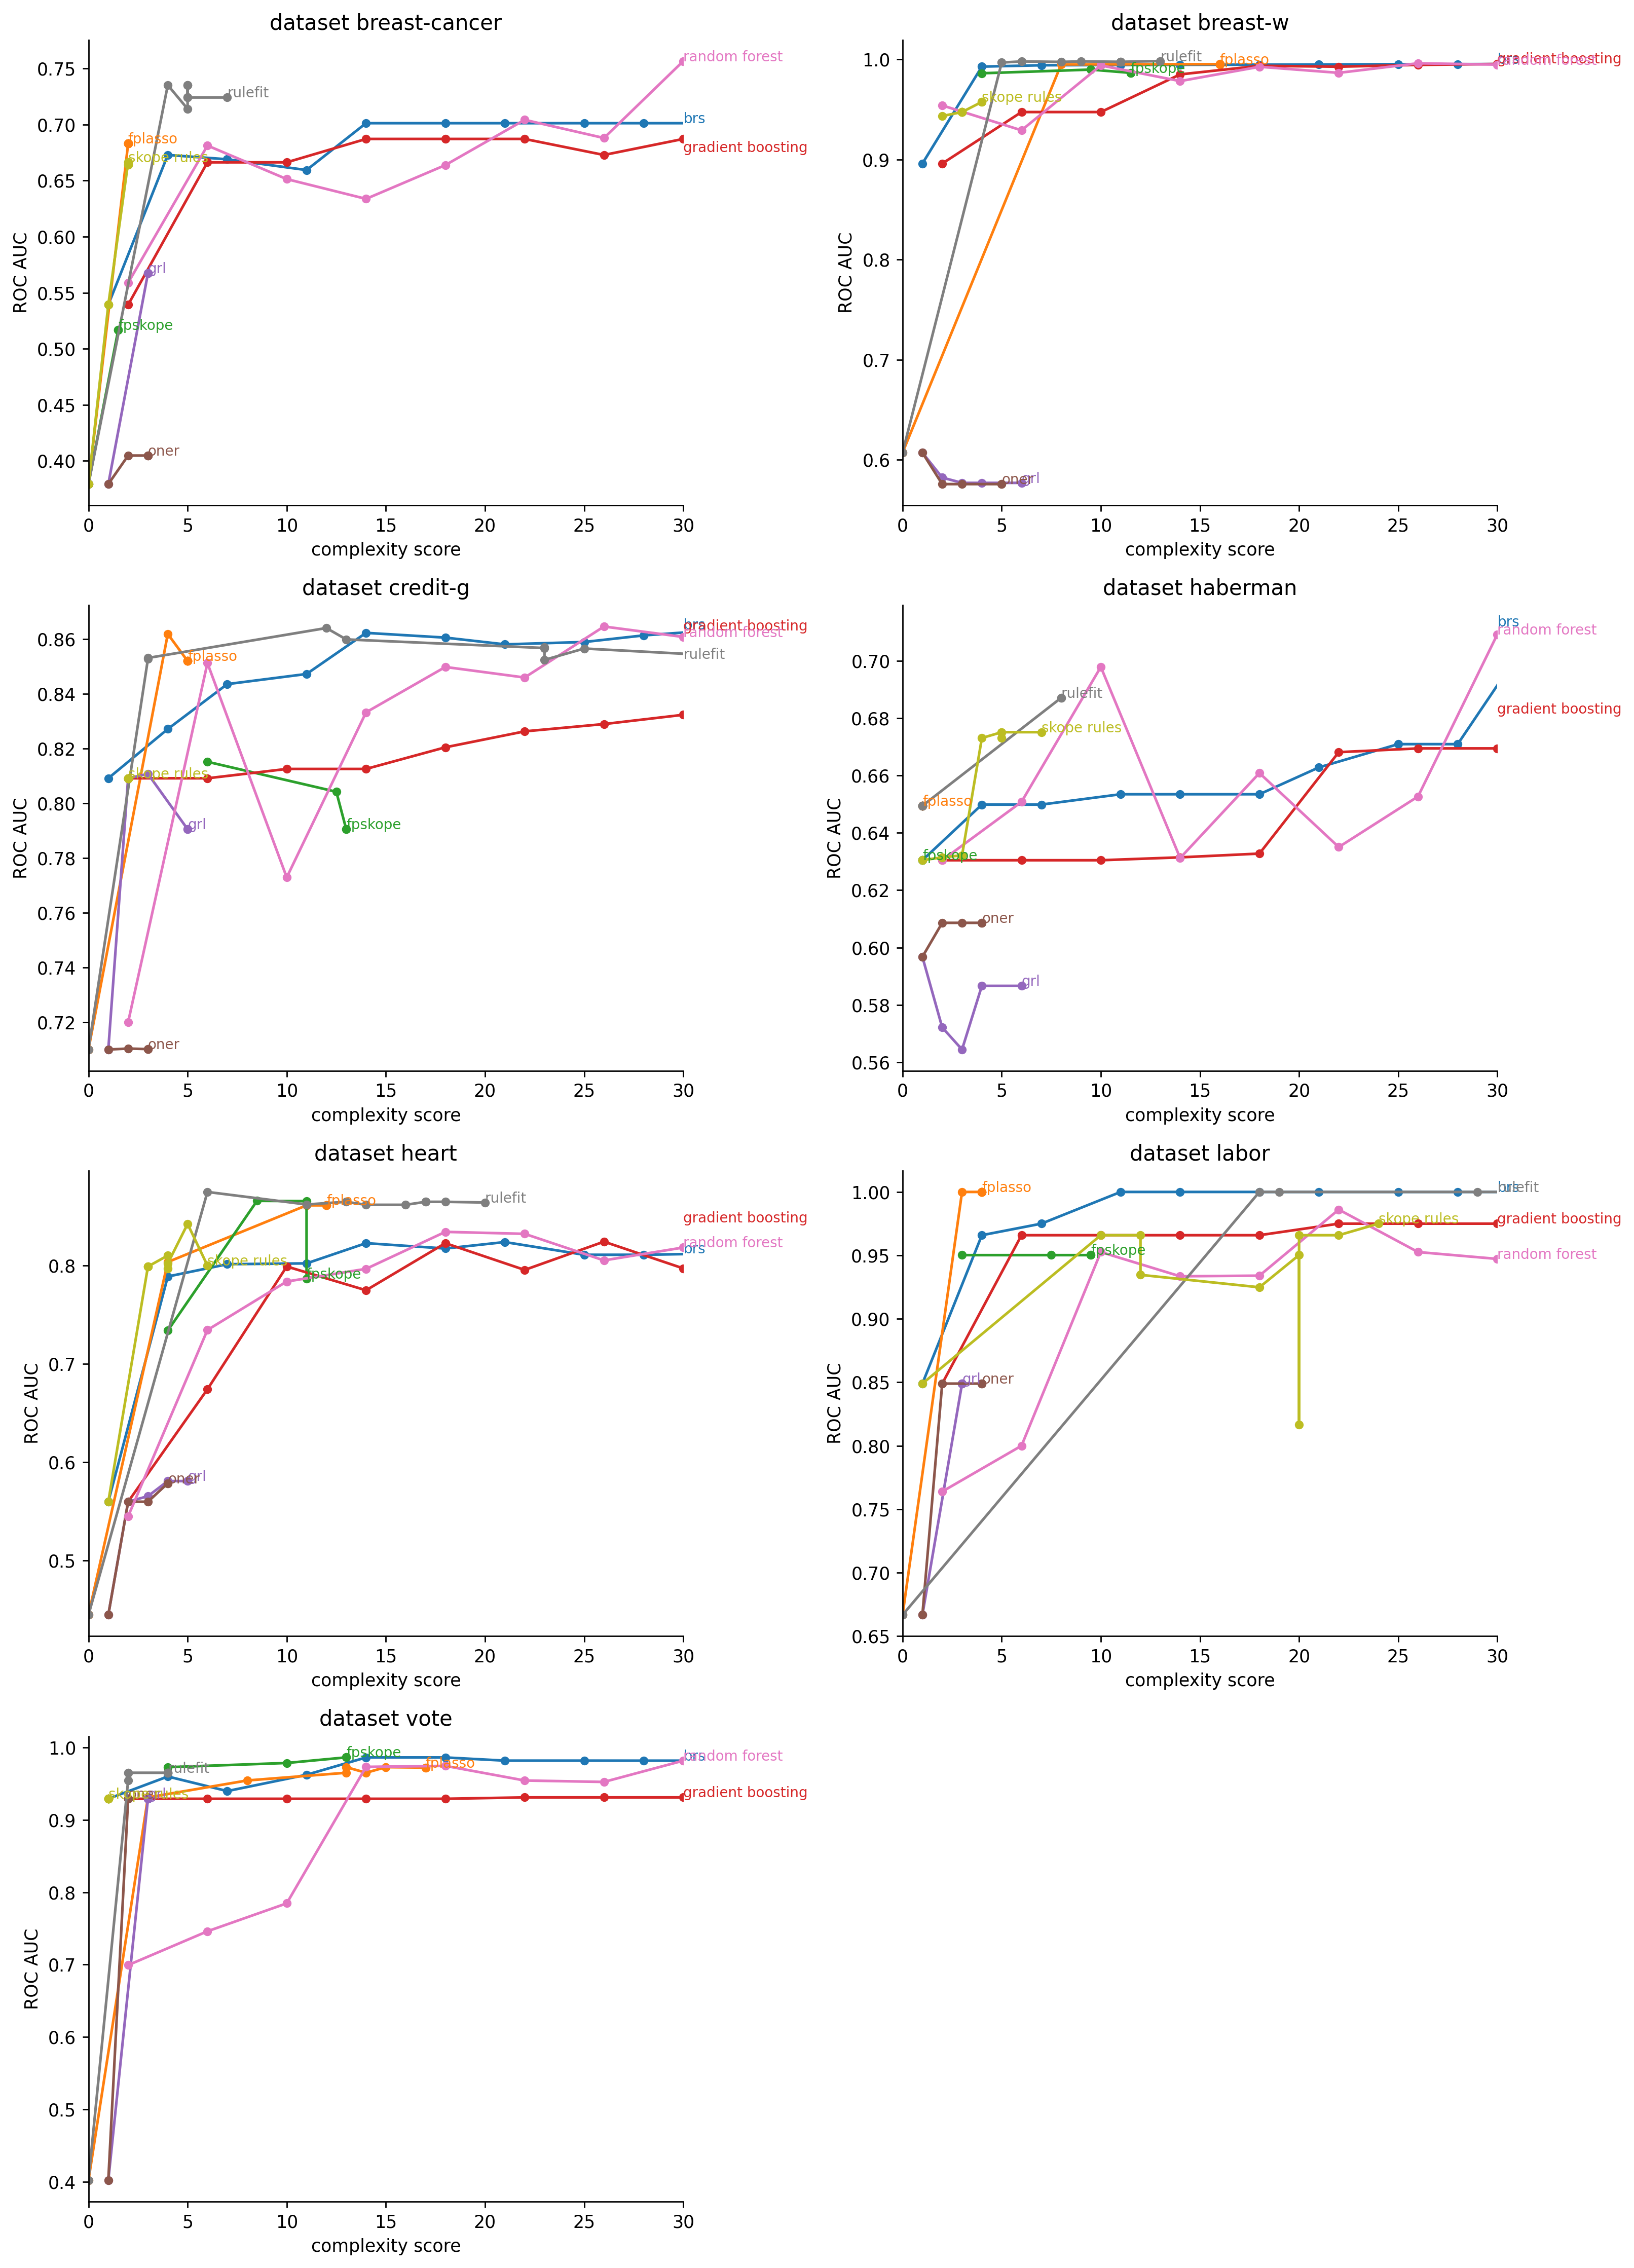

In [131]:
viz.viz_comparison_datasets(test_results, cols=2, figsize=(13, 18), test=True)
plt.show()

# check each model

In [128]:
!python experiments/compare_models.py --model skope_rules --ignore_cache --test

100%|█████████████████████████████████████████████| 7/7 [00:32<00:00,  4.67s/it]


In [130]:
# df = get_comparison_result(MODEL_COMPARISON_PATH, 'random_forest')['df']
# df.loc[:, ['PRAUC' in c for c in df.columns]]
# get_comparison_result(MODEL_COMPARISON_PATH, 'skope_rules', test=True)['df']

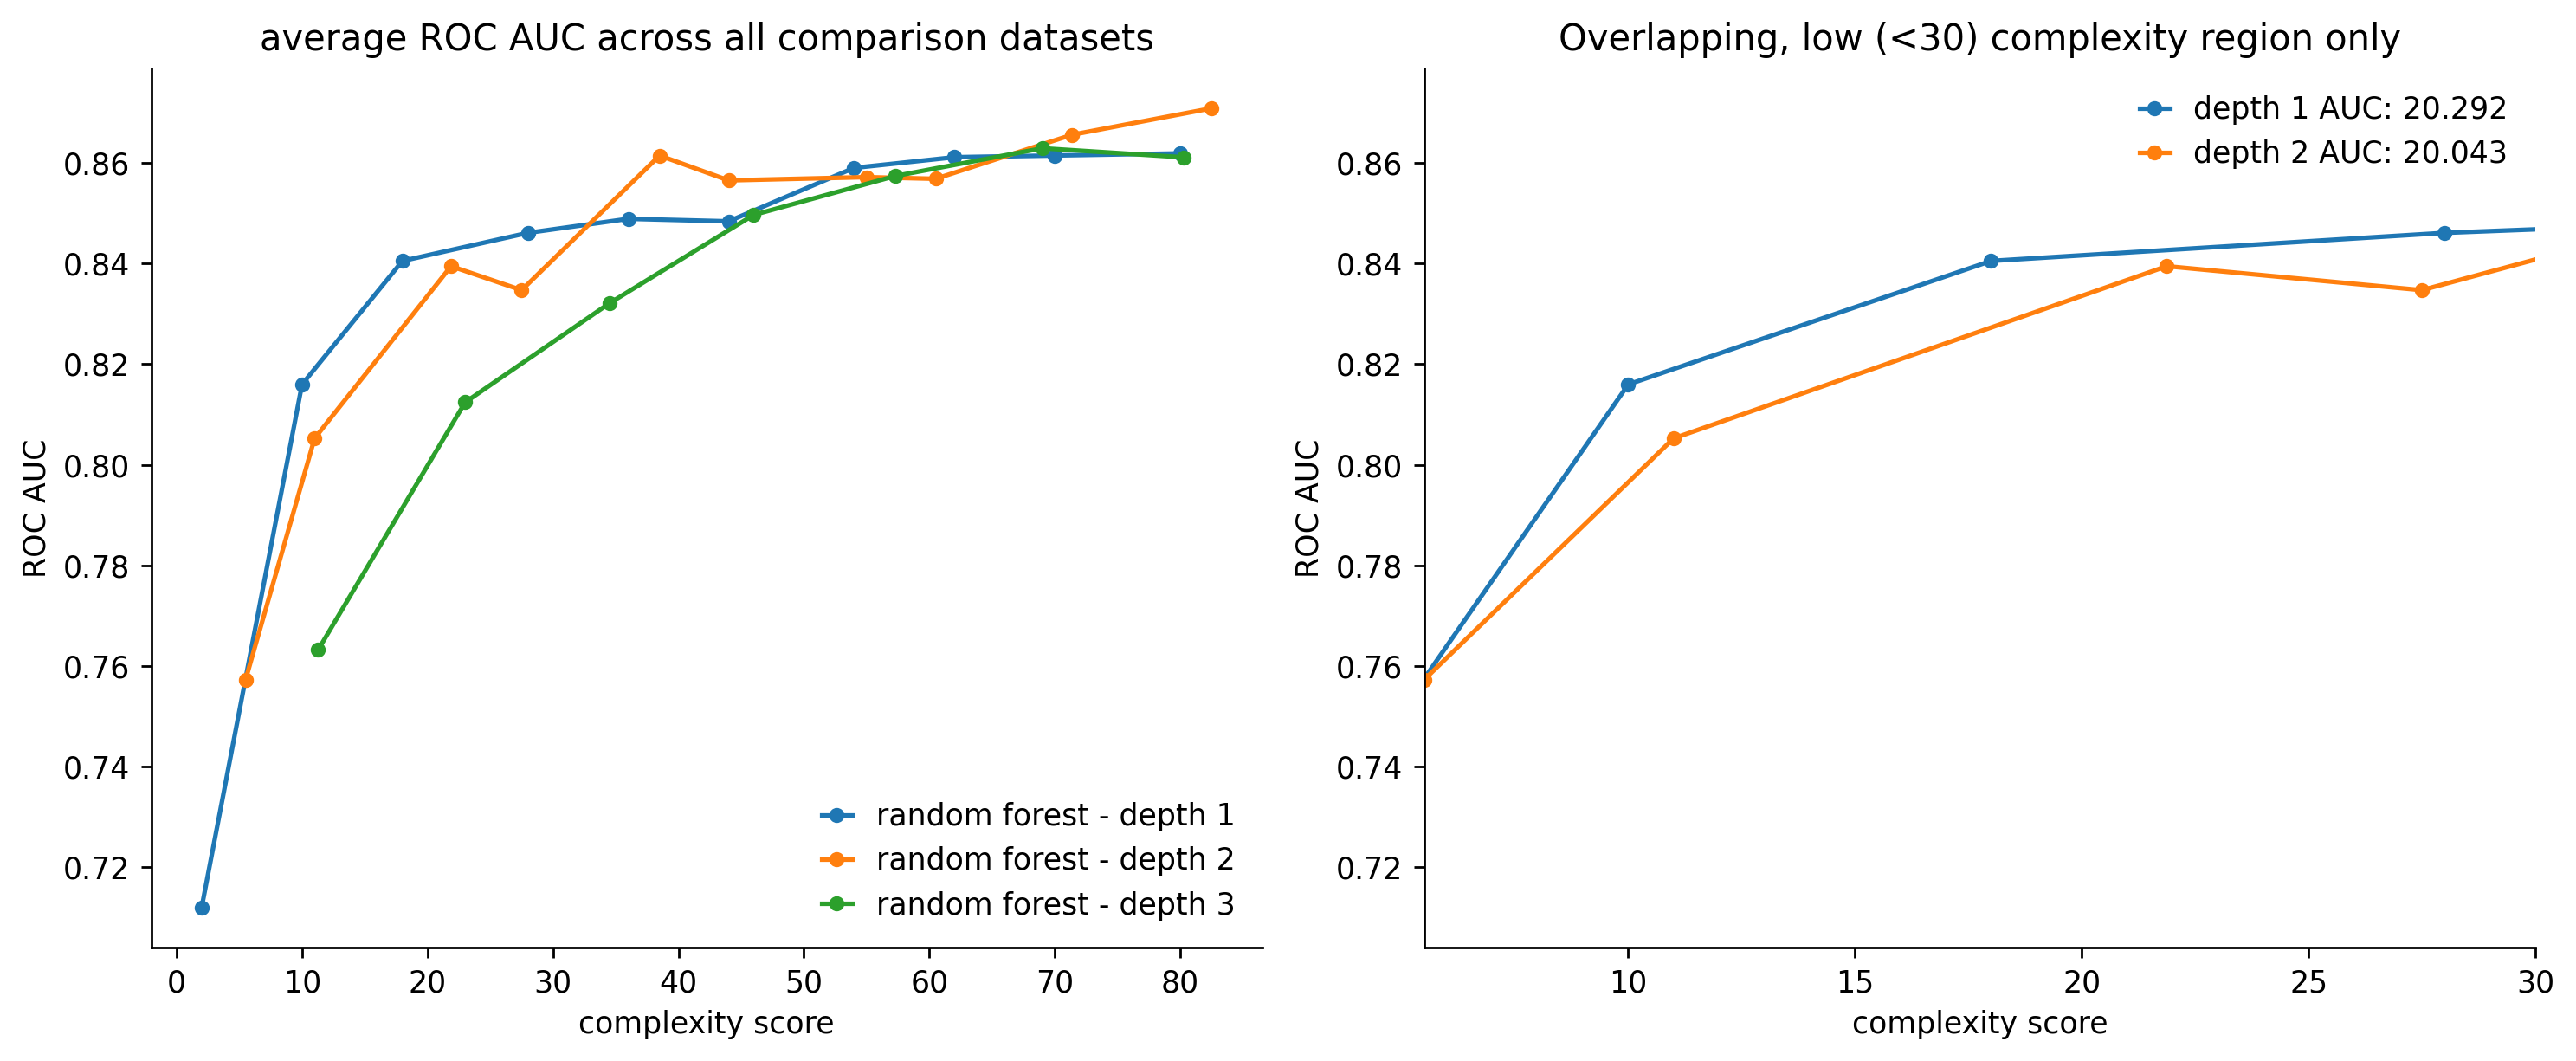

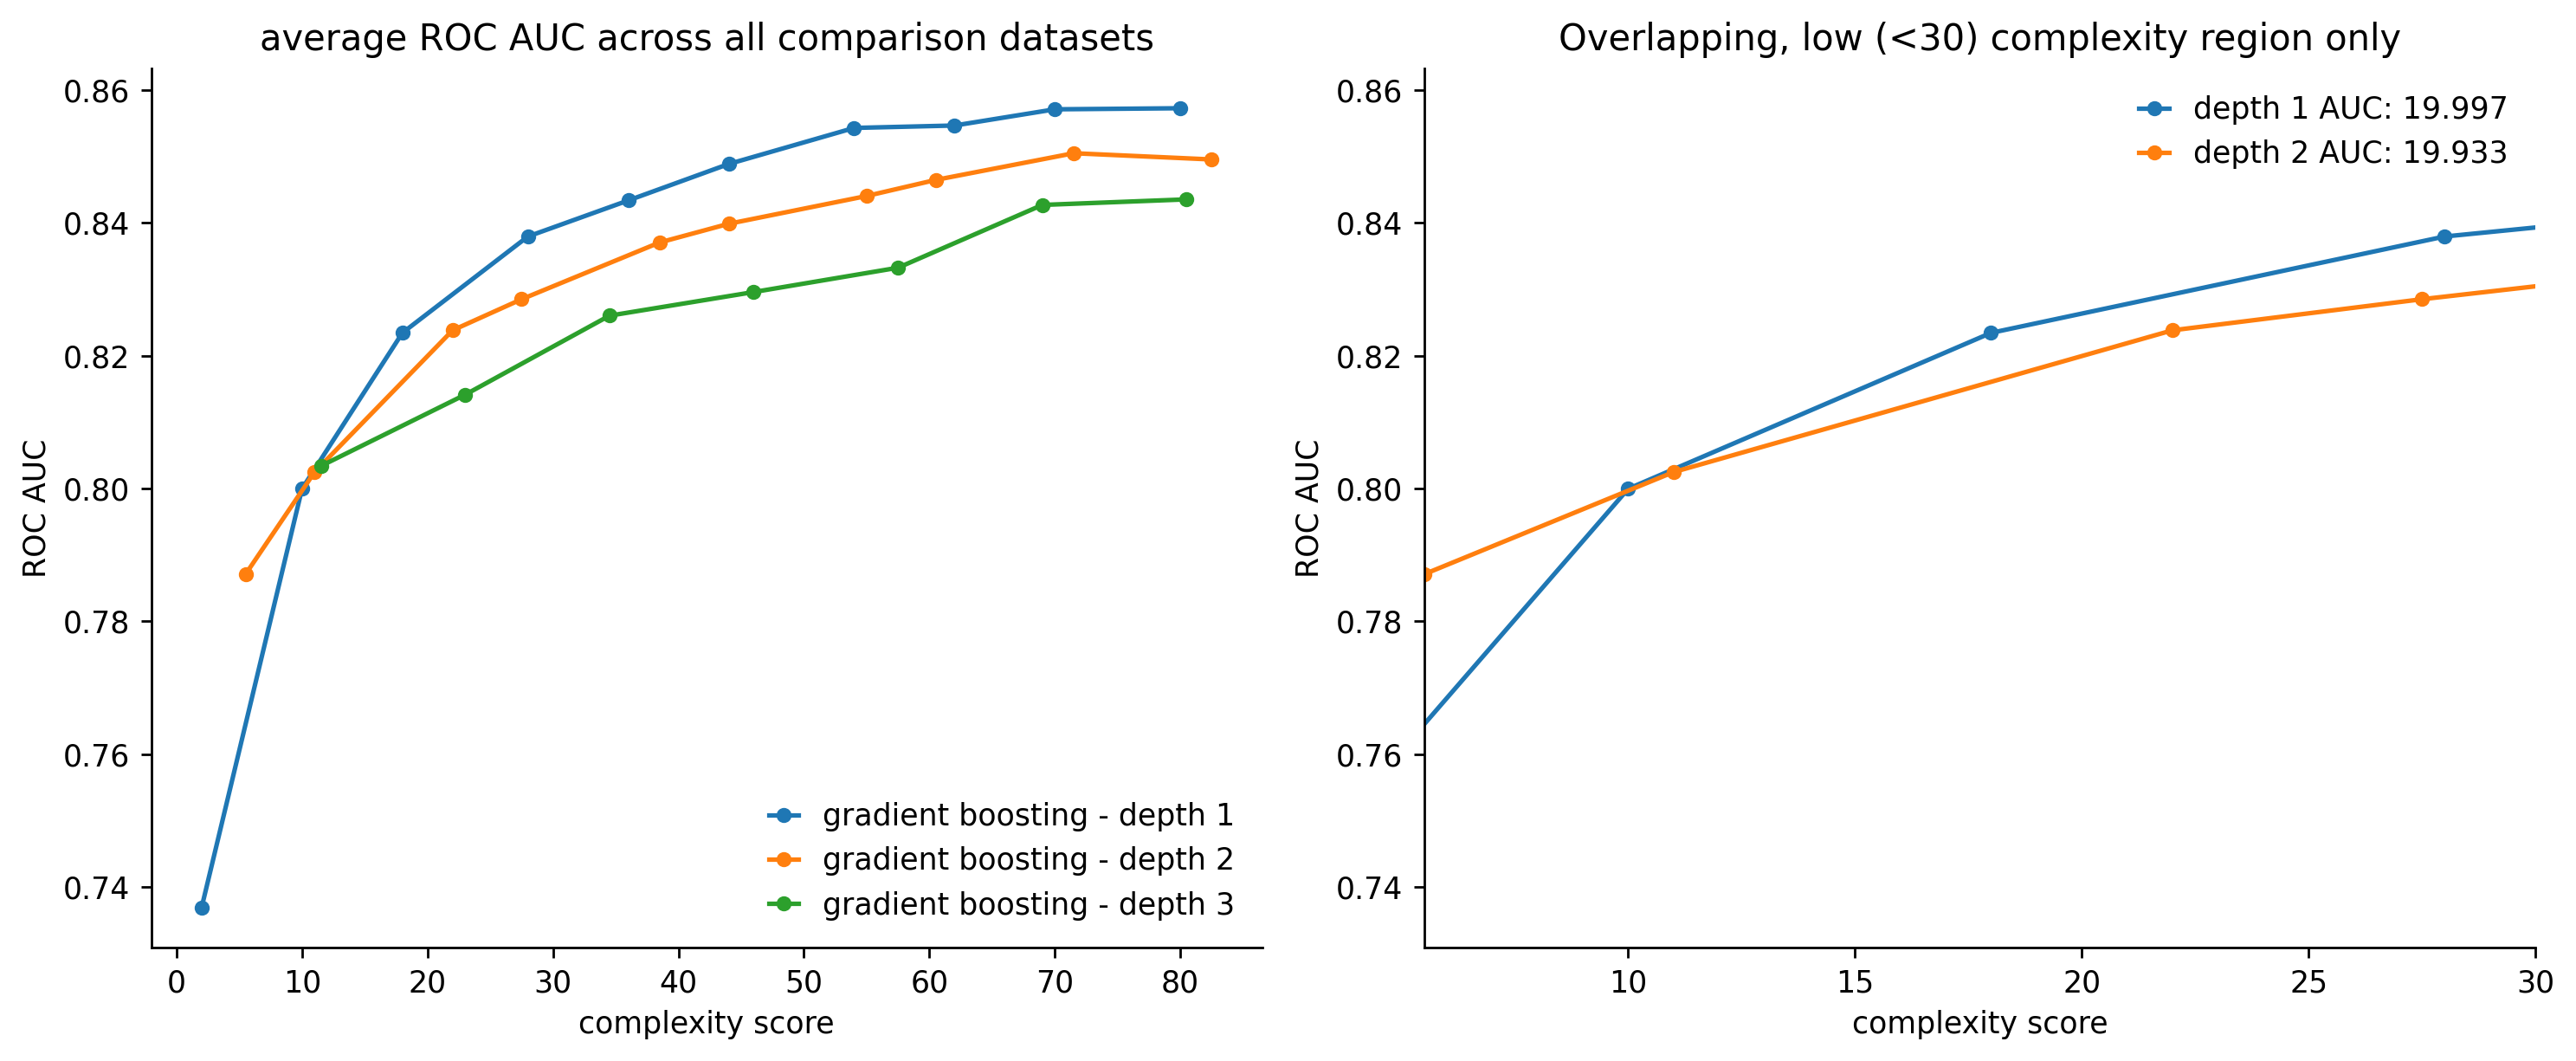

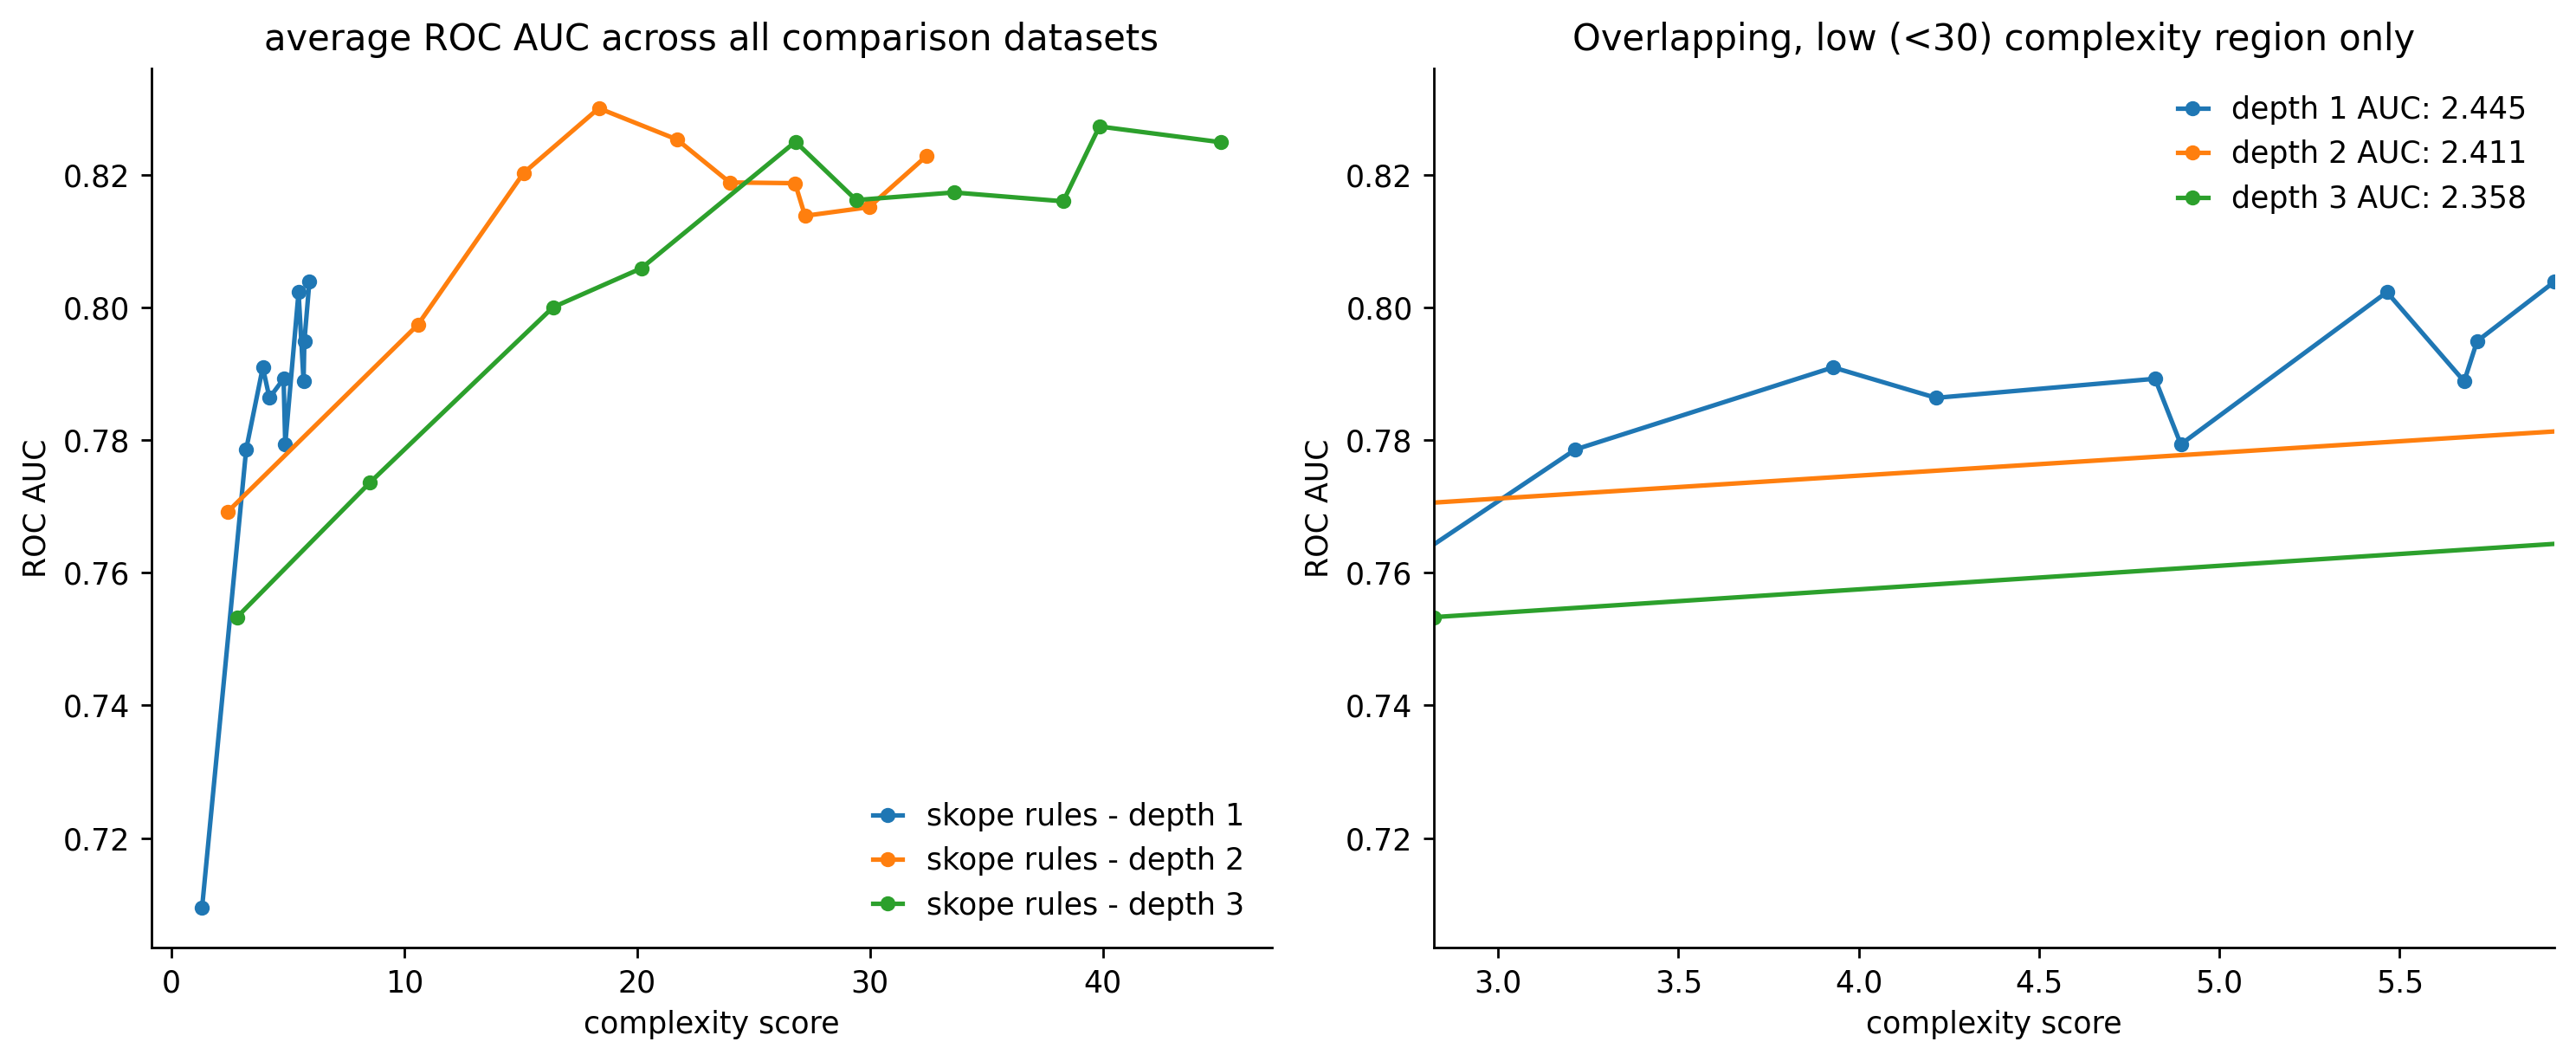

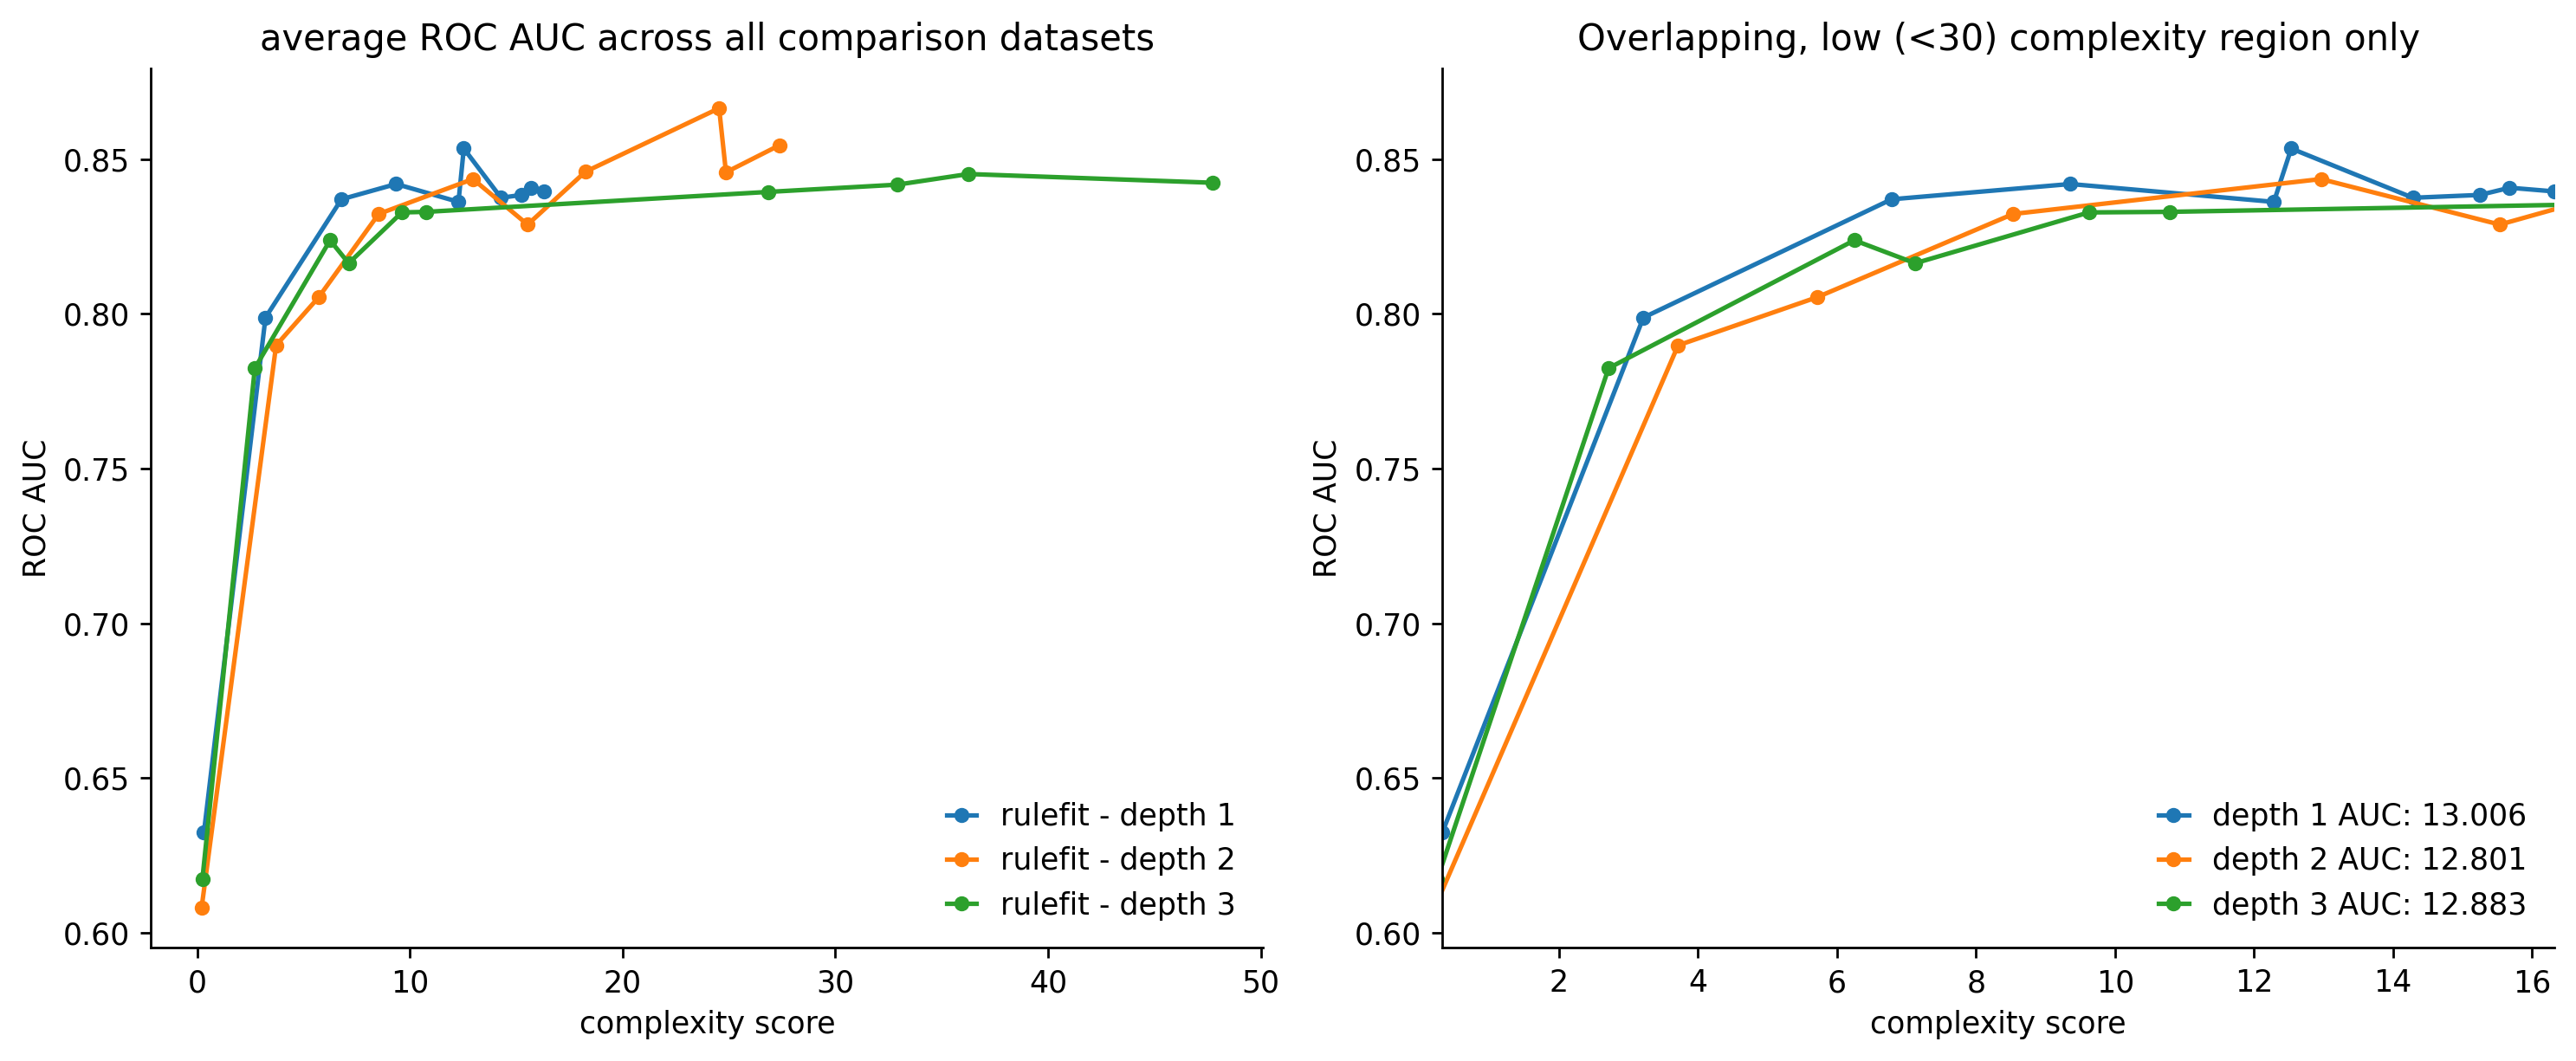

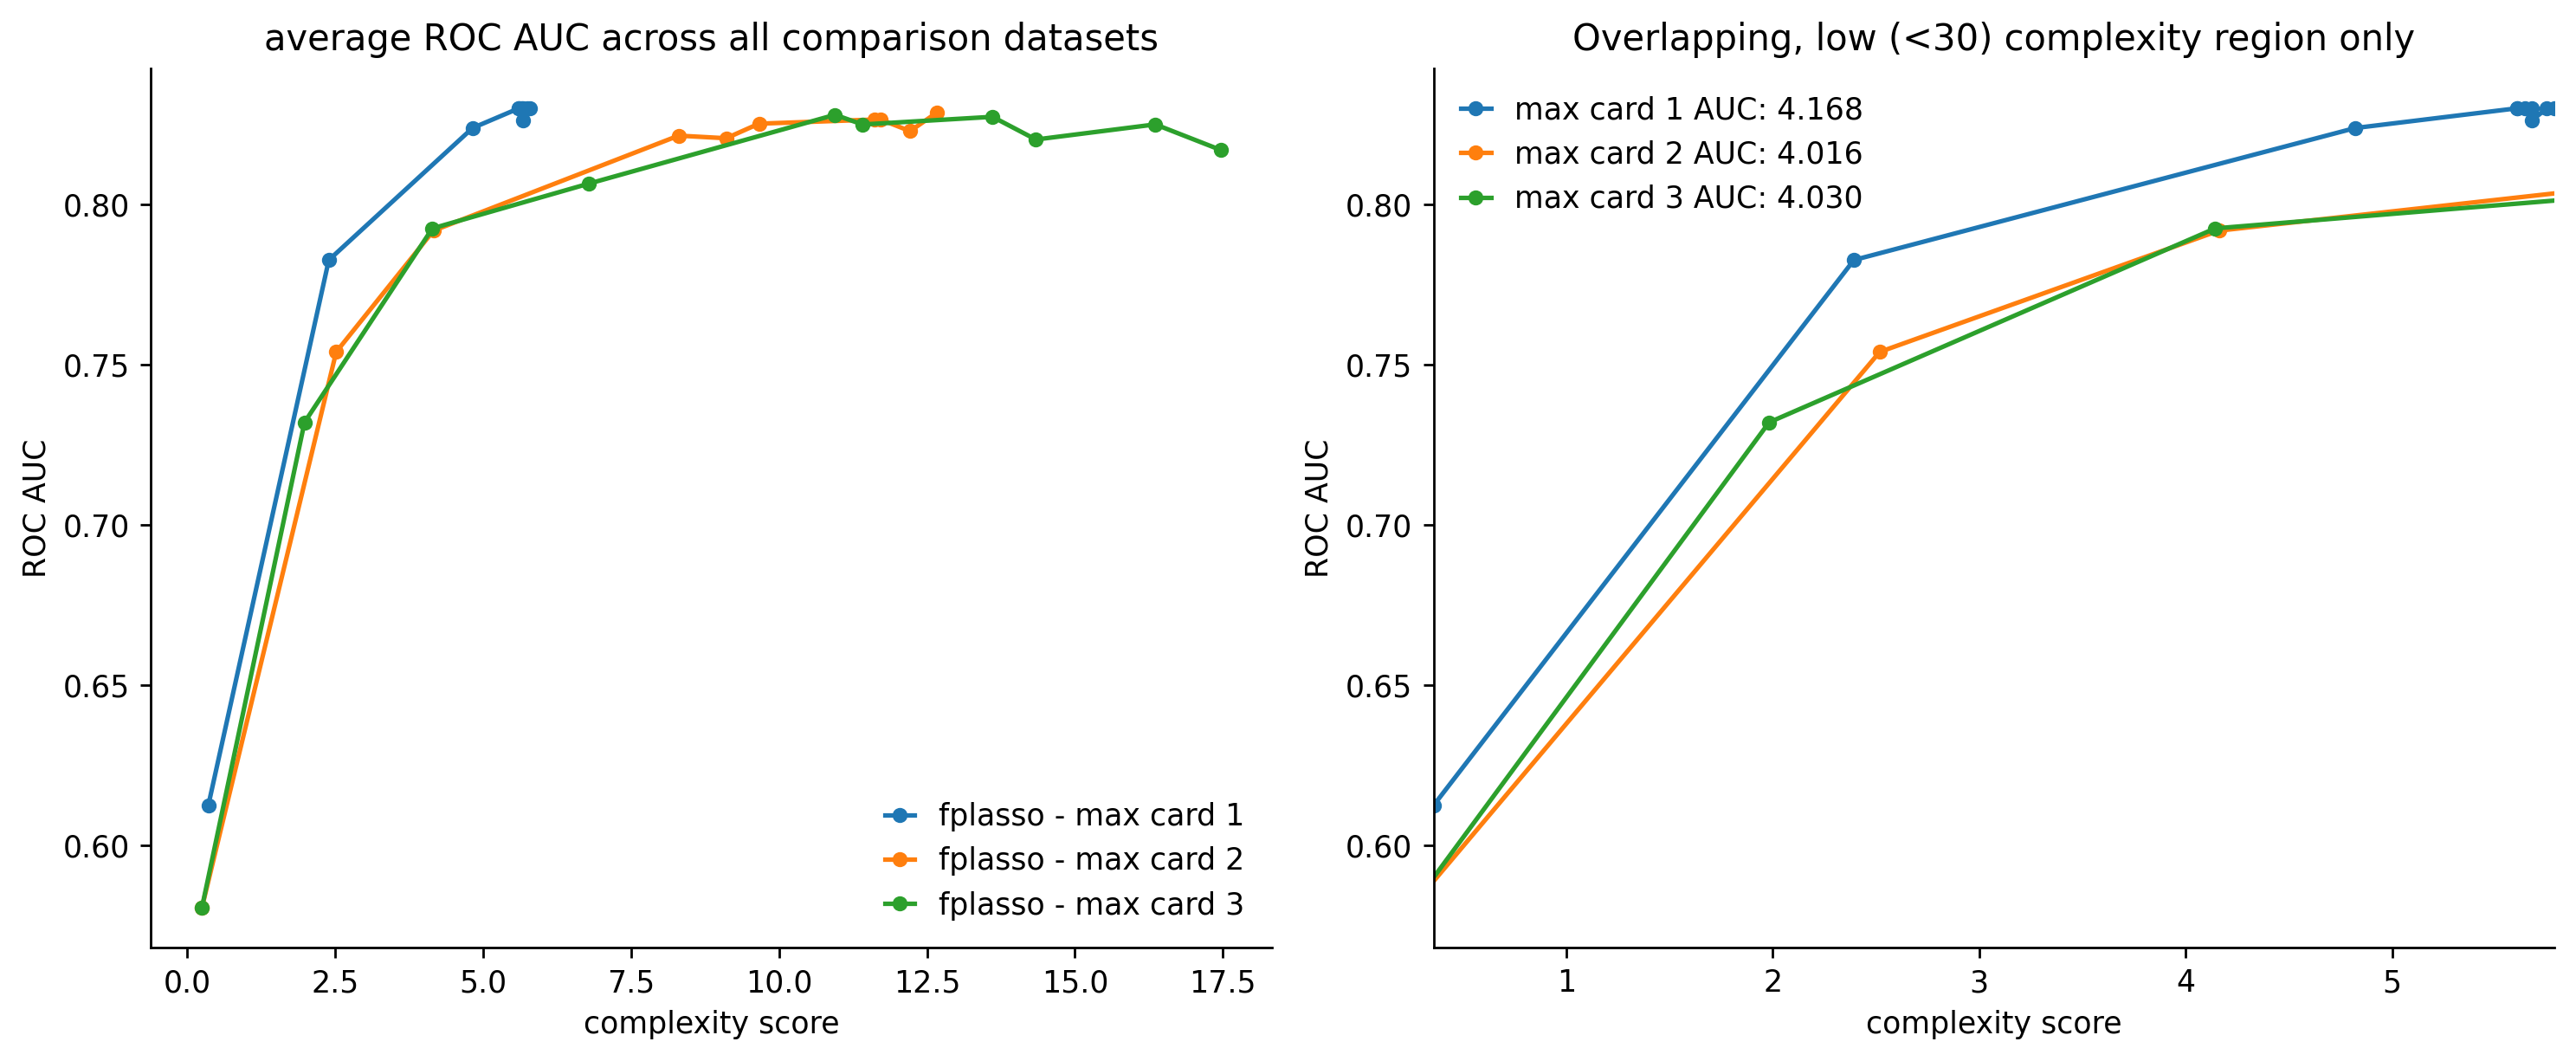

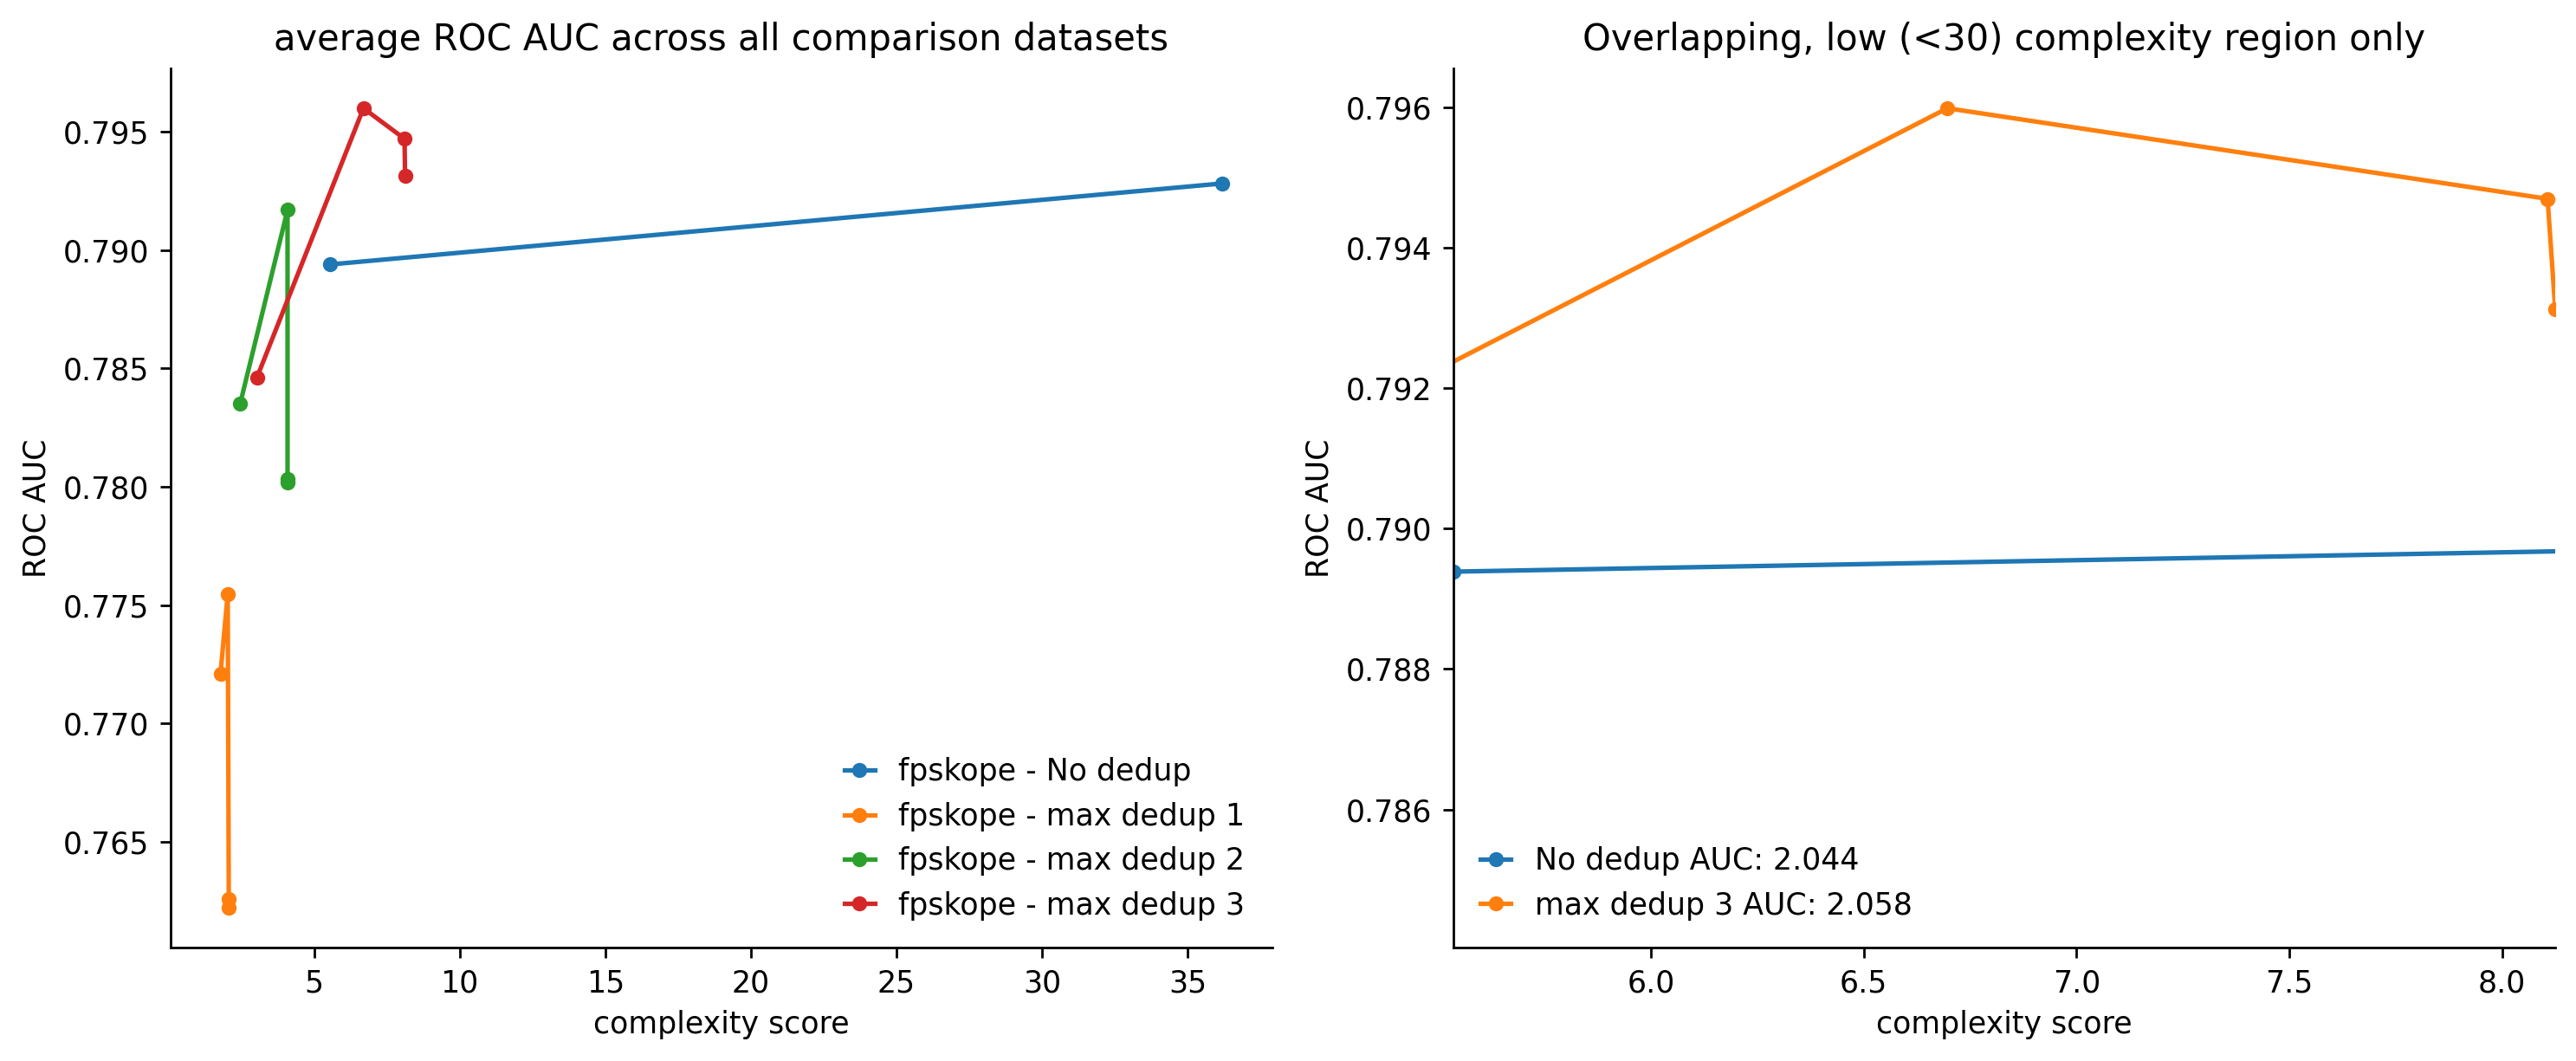

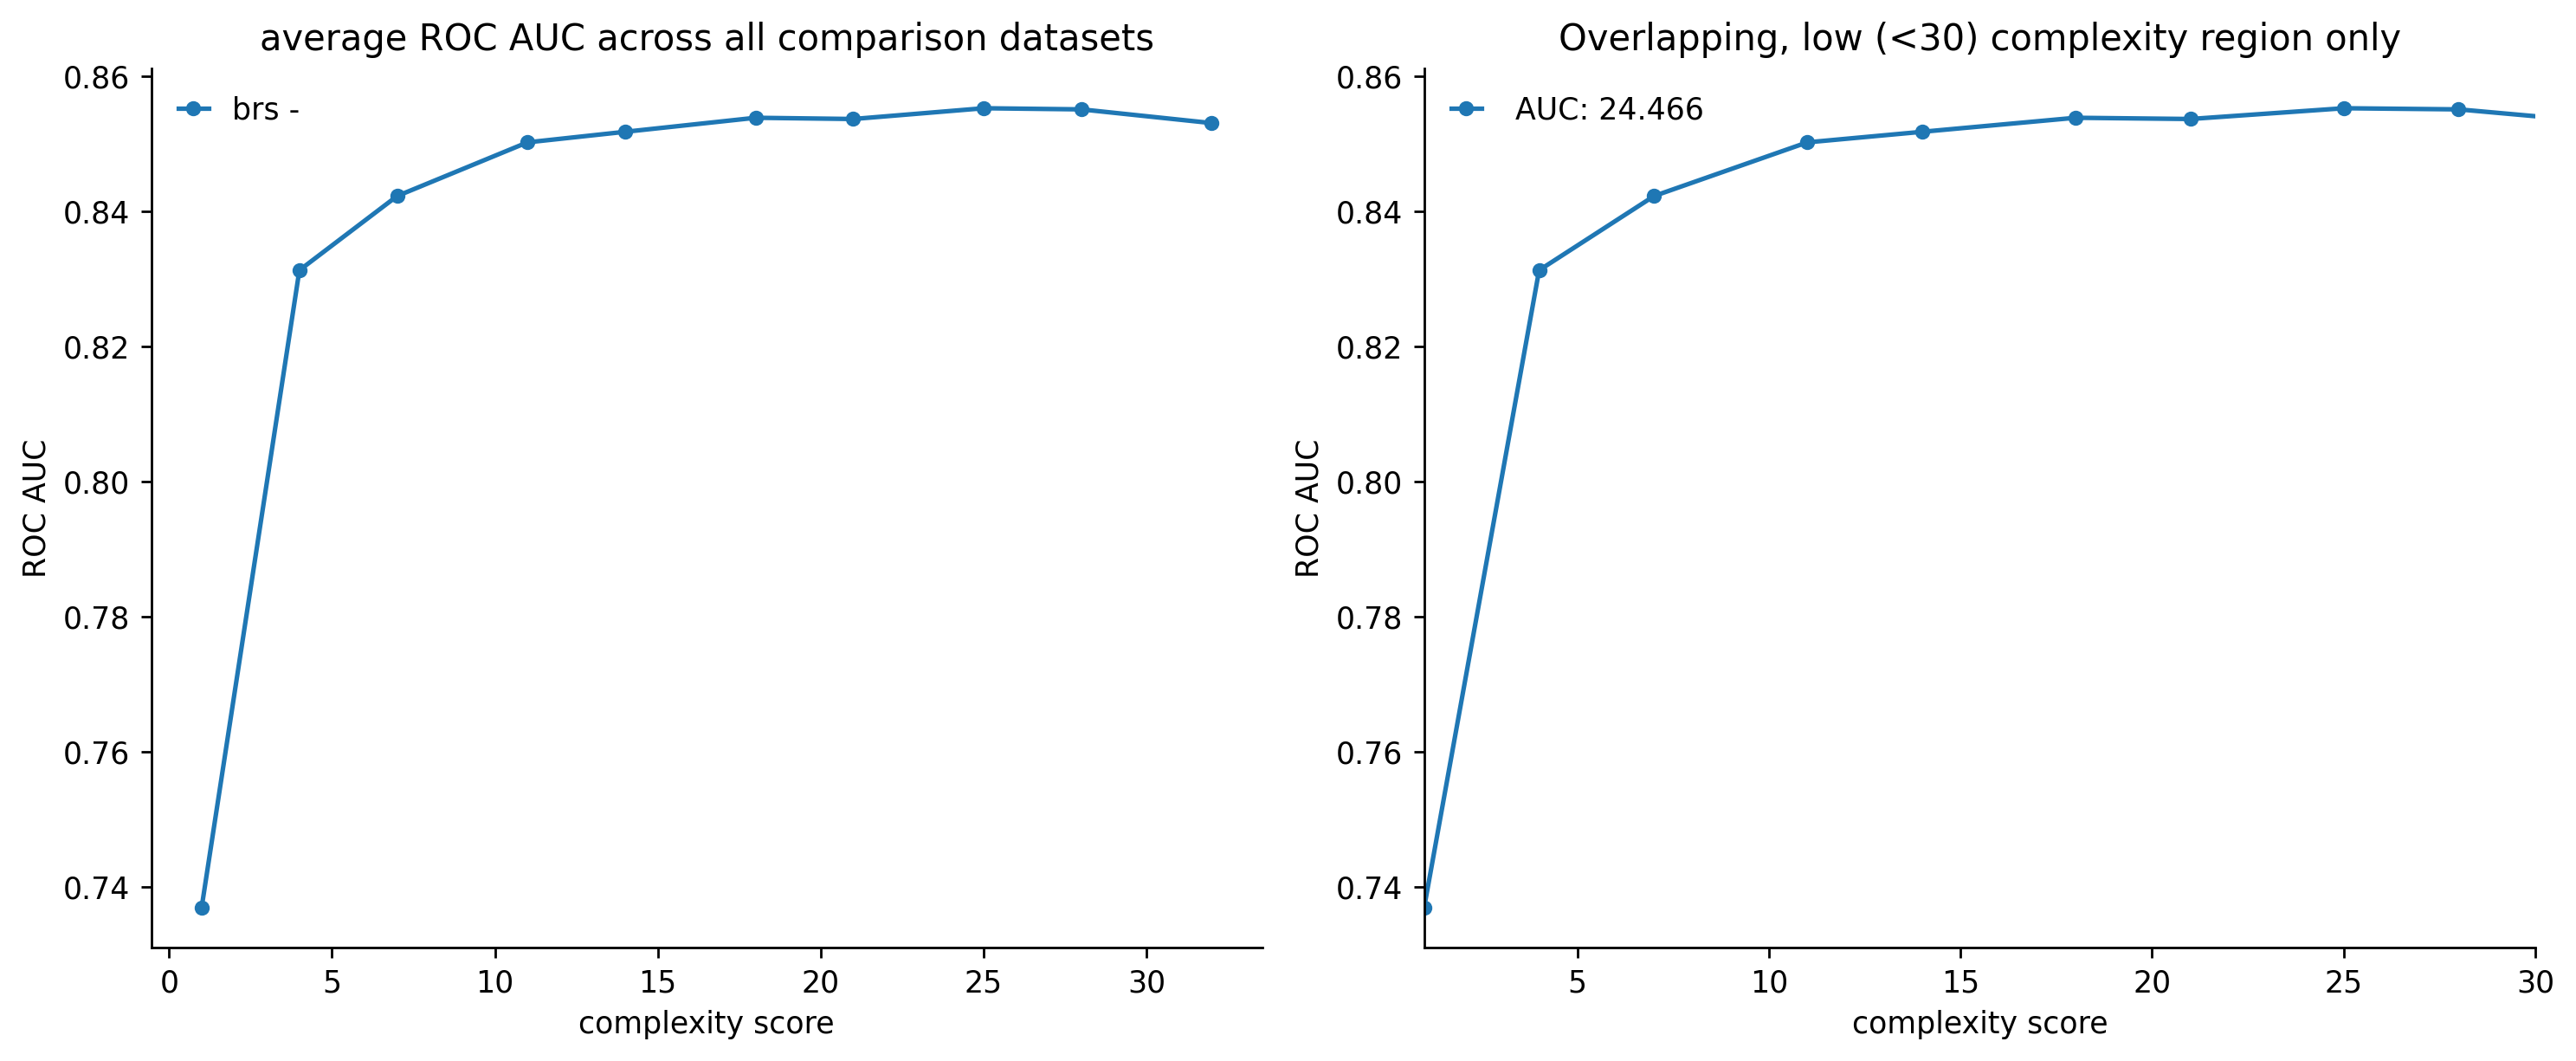

In [113]:
for model_name in ['random_forest', 'gradient_boosting', 'skope_rules', 
              'rulefit', 'fplasso', 'fpskope', 'brs']:
    comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, model_name)
    viz.viz_comparison_val_average(comparison_result, 'PRAUC')
    plt.show()